#Intro
* we previosuly looked at DISCOVR magnetic field and try to analyse its frequency with Fourrier transform but no success as very radnom and lots of noise -> we decided to look at extreme event only
* Then looked at earth kp mag field movemeent compared to Discovr data event
* Looked at how particles are themselved measured during those  
* The trained many binary model (will earth kp > 6) based on apropriate model (binary_classifier, RNNs, ANNs)
* ANNs most succesful -> so here fine tune it

## I - pre data
* concat date, clean null / duplicate, put earth and satellite on same timeline (15mn) via average and interpolation
* normalize and split target for features with binayr limit (kp > 6)



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.max_rows = 60

from google.colab import drive
drive.mount('/content/drive')

dsc_fc_2016 = "/content/drive/My Drive/NASA Challenge/dsc_fc_summed_spectra_2016_v01.csv"
dsc_fc_2017 = "/content/drive/My Drive/NASA Challenge/dsc_fc_summed_spectra_2017_v01.csv"
dsc_fc_2018 = "/content/drive/My Drive/NASA Challenge/dsc_fc_summed_spectra_2018_v01.csv"
dsc_fc_2019 = "/content/drive/My Drive/NASA Challenge/dsc_fc_summed_spectra_2019_v01.csv"
dsc_fc_2020 = "/content/drive/My Drive/NASA Challenge/dsc_fc_summed_spectra_2020_v01.csv"
dsc_fc_2021 = "/content/drive/My Drive/NASA Challenge/dsc_fc_summed_spectra_2021_v01.csv"
dsc_fc_2022 = "/content/drive/My Drive/NASA Challenge/dsc_fc_summed_spectra_2022_v01.csv"
dsc_fc_2023 = "/content/drive/My Drive/NASA Challenge/dsc_fc_summed_spectra_2023_v01.csv"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
d_2017 = pd.read_csv(dsc_fc_2017)
d_2018 = pd.read_csv(dsc_fc_2018)
d_2019 = pd.read_csv(dsc_fc_2019)
d_2020 = pd.read_csv(dsc_fc_2020)
d_2021 = pd.read_csv(dsc_fc_2021)
d_2022 = pd.read_csv(dsc_fc_2022)
d_2023 = pd.read_csv(dsc_fc_2023)


#d_.append([pd.read_csv(data) for data in csv_list], ignore_index = True)

prtcles = [f'p_{x}' for x in range(0,50)]
vctr = ['vec_1', 'vec_2', 'vec_3']
for data in [d_2017, d_2018, d_2019, d_2020, d_2021, d_2022, d_2023]:
    data.columns = ['Timestamp'] + vctr + prtcles
df = pd.concat([d_2017, d_2018, d_2019, d_2020,d_2021, d_2022, d_2023], ignore_index=True)
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
#df.dropna(subset='Timestamp', inplace = True)
df.tail()

,Timestamp,vec_1,vec_2,vec_3,p_0,p_1,p_2,p_3,p_4,p_5,...,p_40,p_41,p_42,p_43,p_44,p_45,p_46,p_47,p_48,p_49
2993748,2023-05-02 23:55:00,4.33665,2.80127,0.954633,1.004790,0.231726,4.64757,0.626576,3.54595,0.231726,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2993749,2023-05-02 23:56:00,4.66778,2.10582,1.260660,0.781621,0.231726,5.97222,0.360648,3.39143,0.231726,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2993750,2023-05-02 23:57:00,4.28322,3.02154,0.927773,0.854185,0.231726,8.10454,2.025800,4.22000,0.231726,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2993751,2023-05-02 23:58:00,4.31376,2.67727,1.723270,0.801559,0.231726,12.76210,2.818550,4.82242,0.301864,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2993752,2023-05-02 23:59:00,4.51542,2.30317,1.832570,2.265740,0.231726,11.68700,1.892900,2.39384,0.231726,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df.dropna(inplace=True)
df.drop_duplicates(subset=['Timestamp'], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2968055 entries, 0 to 2993752
Data columns (total 54 columns):
 #   Column     Dtype         
---  ------     -----         
 0   Timestamp  datetime64[ns]
 1   vec_1      float64       
 2   vec_2      float64       
 3   vec_3      float64       
 4   p_0        float64       
 5   p_1        float64       
 6   p_2        float64       
 7   p_3        float64       
 8   p_4        float64       
 9   p_5        float64       
 10  p_6        float64       
 11  p_7        float64       
 12  p_8        float64       
 13  p_9        float64       
 14  p_10       float64       
 15  p_11       float64       
 16  p_12       float64       
 17  p_13       float64       
 18  p_14       float64       
 19  p_15       float64       
 20  p_16       float64       
 21  p_17       float64       
 22  p_18       float64       
 23  p_19       float64       
 24  p_20       float64       
 25  p_21       float64       
 26  p_22       flo

In [ ]:
df.set_index('Timestamp', inplace=True)
df_15mn = df.resample('15T').mean()
df_15mn.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 222048 entries, 2017-01-01 00:00:00 to 2023-05-02 23:45:00
Freq: 15T
Data columns (total 53 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   vec_1   197972 non-null  float64
 1   vec_2   197972 non-null  float64
 2   vec_3   197972 non-null  float64
 3   p_0     197972 non-null  float64
 4   p_1     197972 non-null  float64
 5   p_2     197972 non-null  float64
 6   p_3     197972 non-null  float64
 7   p_4     197972 non-null  float64
 8   p_5     197972 non-null  float64
 9   p_6     197972 non-null  float64
 10  p_7     197972 non-null  float64
 11  p_8     197972 non-null  float64
 12  p_9     197972 non-null  float64
 13  p_10    197972 non-null  float64
 14  p_11    197972 non-null  float64
 15  p_12    197972 non-null  float64
 16  p_13    197972 non-null  float64
 17  p_14    197972 non-null  float64
 18  p_15    197972 non-null  float64
 19  p_16    197972 non-null  float64
 20  p_17

In [ ]:
path_kp = "/content/drive/MyDrive/NASA Challenge/KP Values.xlsx"
xls = pd.ExcelFile(path_kp)

# Process the 2017 sheet
df_2017 = xls.parse('2017')
df_2017 = df_2017[['year', 'month', 'day', 'hour', 'Actual Kp']].dropna()
df_2017['datetime'] = pd.to_datetime(df_2017[['year', 'month', 'day', 'hour']])
df_2017 = df_2017[['datetime', 'Actual Kp']].rename(columns={'Actual Kp': 'kp'})

# Process the 2018 sheet
df_2018_original = xls.parse('2018')
df_2018 = df_2018_original.iloc[:, [10, 12]].rename(columns={df_2018_original.columns[10]: 'datetime', df_2018_original.columns[12]: 'kp'})
df_2018['datetime'] = pd.to_datetime(df_2018['datetime'])
df_2018['kp'] = df_2018['kp'] / 1000
df_2018['date'] = df_2018['datetime'].dt.date
df_2018['hour'] = df_2018_original.iloc[:, 11].astype(int)  # Extracting hour from the original data
df_2018['datetime'] = pd.to_datetime(df_2018['date'].astype(str) + ' ' + df_2018['hour'].astype(str) + ':00:00')
df_2018 = df_2018[['datetime', 'kp']]

#process 2019 sheet
# Adjusting the processing for the 2019 sheet
df_2019 = xls.parse('2019')
df_2019 = df_2019[['Year', 'Month', 'Day', 'Hour', 'Fake Kp']].dropna()
df_2019['datetime'] = pd.to_datetime(df_2019[['Year', 'Month', 'Day', 'Hour']])

# Use 'Fake Kp' divided by 1000 as 'kp'
df_2019['kp'] = df_2019['Fake Kp'] / 1000
df_2019 = df_2019[['datetime', 'kp']]


# Load the 2020 sheet and display sample data
df_2020 = xls.parse('2020')
# Extract relevant columns
df_2020 = df_2020[['Year', 'Month', 'Day', 'Hour', 'Actual Kp']]
df_2020 = df_2020.dropna(subset=['Year', 'Month', 'Day', 'Hour', 'Actual Kp'])
df_2020['datetime'] = pd.to_datetime(df_2020[['Year', 'Month', 'Day', 'Hour']])
df_2020 = df_2020[['datetime', 'Actual Kp']].rename(columns={'Actual Kp': 'kp'})

# Load the 2021 sheet and display sample data
df_2021 = xls.parse('2021')
# Extract relevant columns
df_2021 = df_2021[['Year', 'Month', 'Day', 'Hour', 'Actual Kp']]
df_2021 = df_2021.dropna(subset=['Year', 'Month', 'Day', 'Hour', 'Actual Kp'])
df_2021['datetime'] = pd.to_datetime(df_2021[['Year', 'Month', 'Day', 'Hour']])
df_2021 = df_2021[['datetime', 'Actual Kp']].rename(columns={'Actual Kp': 'kp'})

# Load the 2022 sheet and display sample data
df_2022 = xls.parse('2022')
# Extract relevant columns
df_2022 = df_2022[['Year', 'Month', 'Day', 'Hour', 'Actual Kp']]
df_2022 = df_2022.dropna(subset=['Year', 'Month', 'Day', 'Hour', 'Actual Kp'])
df_2022['datetime'] = pd.to_datetime(df_2022[['Year', 'Month', 'Day', 'Hour']])
df_2022 = df_2022[['datetime', 'Actual Kp']].rename(columns={'Actual Kp': 'kp'})


# Load the 2023 sheet and display sample data
df_2023 = xls.parse('2023')
# Extract relevant columns
df_2023 = df_2023[['Year', 'Month', 'Day', 'Hour', 'Actual Kp']]
df_2023 = df_2023.dropna(subset=['Year', 'Month', 'Day', 'Hour', 'Actual Kp'])
df_2023['datetime'] = pd.to_datetime(df_2023[['Year', 'Month', 'Day', 'Hour']])
df_2023 = df_2023[['datetime', 'Actual Kp']].rename(columns={'Actual Kp': 'kp'})


In [ ]:
df_2023.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2232 entries, 0 to 2231
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   datetime  2232 non-null   datetime64[ns]
 1   kp        2232 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 52.3 KB


In [ ]:
df_2023.head()

,datetime,kp
0,2023-01-01 21:00:00,4.000
1,2023-01-01 18:00:00,3.667
2,2023-01-01 03:00:00,3.000
3,2023-01-01 09:00:00,2.667
4,2023-01-01 15:00:00,2.667


In [ ]:
kp_earth = pd.concat([df_2017, df_2018, df_2019, df_2020, df_2021, df_2022, df_2023], ignore_index=True)
kp_earth.head()

,datetime,kp
0,2017-09-08 12:00:00,8.333
1,2017-09-08 00:00:00,8.0
2,2017-09-07 21:00:00,7.667
3,2017-09-08 15:00:00,7.333
4,2017-05-28 03:00:00,7.0


In [ ]:
kp_earth = pd.concat([df_2017, df_2018, df_2019, df_2020, df_2021, df_2022, df_2023], ignore_index=True)
# Ensure 'datetime' is in datetime format and set as index
kp_earth['datetime'] = pd.to_datetime(kp_earth['datetime'])
kp_earth.set_index('datetime', inplace=True)
# Sort the index
kp_earth.sort_index(inplace=True)
kp_earth['kp'] = pd.to_numeric(kp_earth['kp'], errors='coerce')
kp_earth.dropna(inplace=True)
# Resample to 15-minute intervals
df_resampled = kp_earth.resample('15T').asfreq()
# Interpolate using a polynomial method
df_interpolated = df_resampled.interpolate(method='linear')
df_interpolated
#df_resampled_15min

,kp
datetime,
2017-01-01 00:00:00,3.333000
2017-01-01 00:15:00,3.360833
2017-01-01 00:30:00,3.388667
2017-01-01 00:45:00,3.416500
2017-01-01 01:00:00,3.444333
...,...
2023-10-06 20:00:00,2.222333
2023-10-06 20:15:00,2.416750
2023-10-06 20:30:00,2.611167


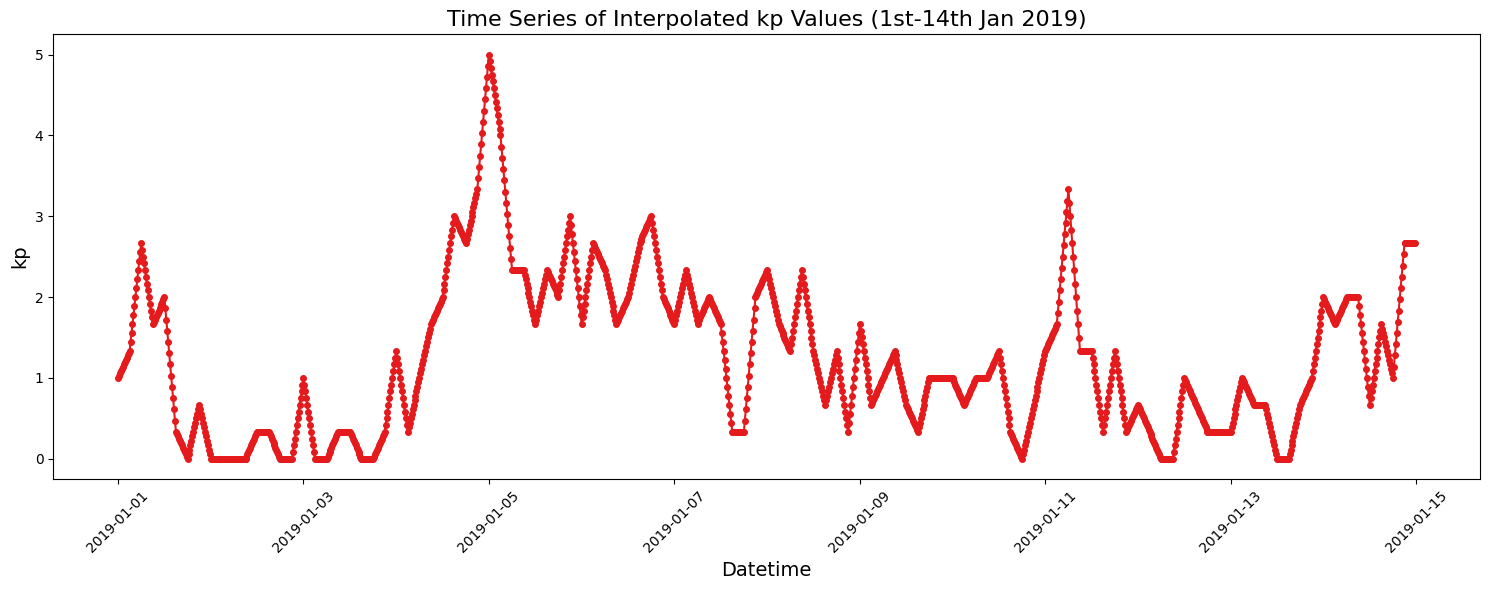

In [ ]:
df_interpolated.reset_index(inplace=True)
subset_interpolated = df_interpolated[(df_interpolated['datetime'] >= '2019-01-01') & (df_interpolated['datetime'] < '2019-01-15')]

# Plotting the subset of the interpolated data
plt.figure(figsize=(15, 6))
plt.plot(subset_interpolated['datetime'], subset_interpolated['kp'], color = '#E41A1C', marker='o', linestyle='-', markersize=4)

# Titles and labels
plt.title('Time Series of Interpolated kp Values (1st-14th Jan 2019)', fontsize=16)
plt.xlabel('Datetime', fontsize=14)
plt.ylabel('kp', fontsize=14)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()

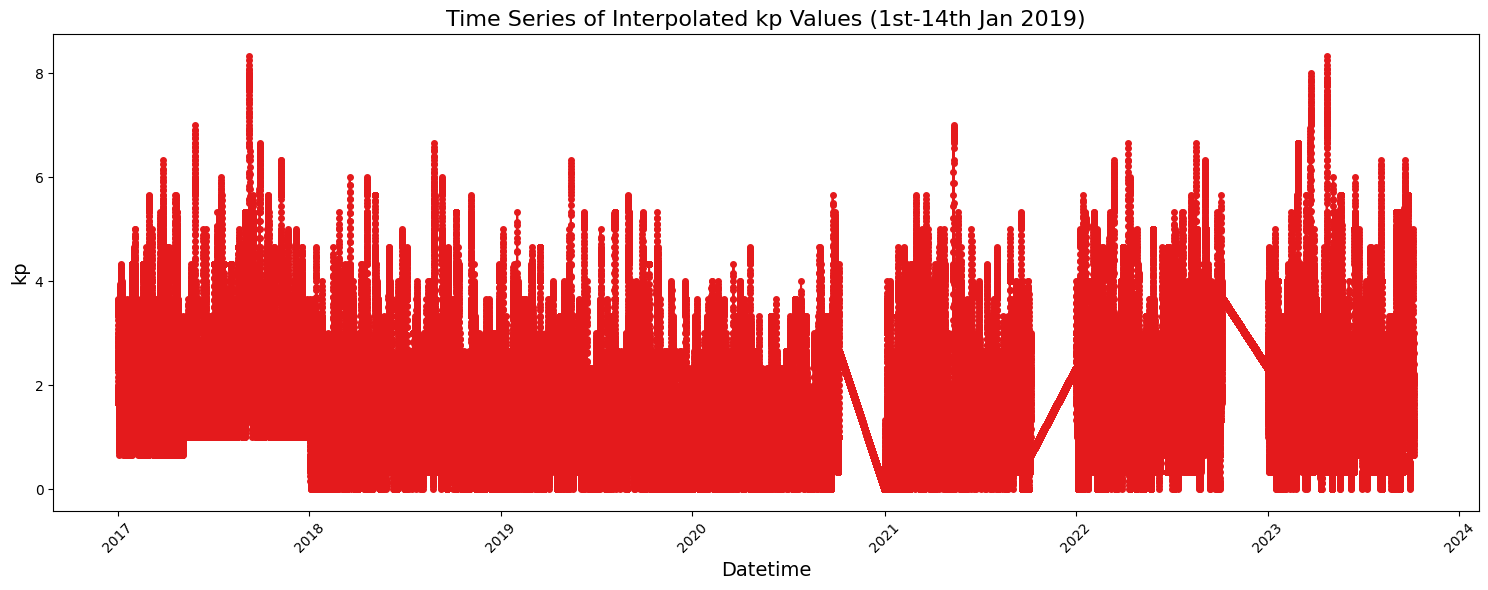

In [ ]:
subset_interpolated = df_interpolated

# Plotting the subset of the interpolated data
plt.figure(figsize=(15, 6))
plt.plot(subset_interpolated['datetime'], subset_interpolated['kp'], color = '#E41A1C', marker='o', linestyle='-', markersize=4)

# Titles and labels
plt.title('Time Series of Interpolated kp Values (1st-14th Jan 2019)', fontsize=16)
plt.xlabel('Datetime', fontsize=14)
plt.ylabel('kp', fontsize=14)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
df_interpolated.set_index('datetime', inplace=True)
merged = pd.merge(df_interpolated, df_15mn, left_index=True, right_index=True, how='inner')
merged.head()

,kp,vec_1,vec_2,vec_3,p_0,p_1,p_2,p_3,p_4,p_5,...,p_40,p_41,p_42,p_43,p_44,p_45,p_46,p_47,p_48,p_49
2017-01-01 00:00:00,3.333000,-5.738590,-2.919362,-2.743846,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-01 00:15:00,3.360833,-3.196144,0.996394,-4.979366,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-01 00:30:00,3.388667,-4.081334,-2.491543,-4.033066,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-01 00:45:00,3.416500,-4.953276,-1.989724,-2.707257,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-01 01:00:00,3.444333,-4.759808,0.713095,-2.470103,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
merged.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 222048 entries, 2017-01-01 00:00:00 to 2023-05-02 23:45:00
Data columns (total 54 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   kp      222048 non-null  float64
 1   vec_1   197972 non-null  float64
 2   vec_2   197972 non-null  float64
 3   vec_3   197972 non-null  float64
 4   p_0     197972 non-null  float64
 5   p_1     197972 non-null  float64
 6   p_2     197972 non-null  float64
 7   p_3     197972 non-null  float64
 8   p_4     197972 non-null  float64
 9   p_5     197972 non-null  float64
 10  p_6     197972 non-null  float64
 11  p_7     197972 non-null  float64
 12  p_8     197972 non-null  float64
 13  p_9     197972 non-null  float64
 14  p_10    197972 non-null  float64
 15  p_11    197972 non-null  float64
 16  p_12    197972 non-null  float64
 17  p_13    197972 non-null  float64
 18  p_14    197972 non-null  float64
 19  p_15    197972 non-null  float64
 20  p_16    197972

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# 1. Handle Missing Values: Drop rows with NaN values
data_clean = merged.dropna()

# 2. Feature Engineering: Select relevant features and target
features = data_clean.loc[:, 'vec_1':'p_49']
target = data_clean['kp']

# 3. Normalization: Normalize the features
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)

# 4. Data Splitting: Split the data into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(
    features_scaled, target, test_size=0.2, random_state=42
)

# Display the shapes of the training and testing data
(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


((158377, 53), (39595, 53), (158377,), (39595,))

In [ ]:
# Convert target to binary
y_train_binary = (y_train > 6).astype(int)
y_test_binary = (y_test > 6).astype(int)

# Train ANN
with one hidden layer of 3 layers of 32 neuron

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

model_deep = models.Sequential([
    layers.Dense(32, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dense(32, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model_deep.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history_deep = model_deep.fit(
    X_train, y_train_binary,
    epochs=100,
    batch_size=32,
    validation_split=0.2
)


Epoch 1/100
3960/3960 [==============================] - 16s 3ms/step - loss: 0.0172 - accuracy: 0.9979 - val_loss: 0.0095 - val_accuracy: 0.9980
Epoch 2/100
3960/3960 [==============================] - 12s 3ms/step - loss: 0.0097 - accuracy: 0.9980 - val_loss: 0.0075 - val_accuracy: 0.9983
Epoch 3/100
3960/3960 [==============================] - 12s 3ms/step - loss: 0.0086 - accuracy: 0.9982 - val_loss: 0.0073 - val_accuracy: 0.9985
Epoch 4/100
3960/3960 [==============================] - 12s 3ms/step - loss: 0.0082 - accuracy: 0.9984 - val_loss: 0.0064 - val_accuracy: 0.9985
Epoch 5/100
3960/3960 [==============================] - 14s 3ms/step - loss: 0.0078 - accuracy: 0.9985 - val_loss: 0.0055 - val_accuracy: 0.9987
Epoch 6/100
3960/3960 [==============================] - 18s 4ms/step - loss: 0.0074 - accuracy: 0.9984 - val_loss: 0.0058 - val_accuracy: 0.9985
Epoch 7/100
3960/3960 [==============================] - 14s 4ms/step - loss: 0.0070 - accuracy: 0.9985 - val_loss: 0.0053 -

# observe accuracy

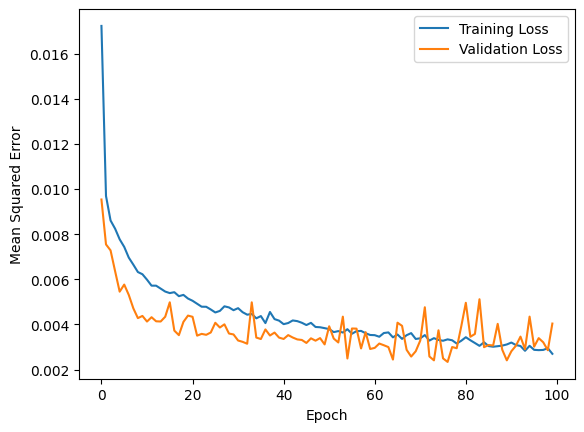

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history_deep.history['loss'], label='Training Loss')
plt.plot(history_deep.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()


In [ ]:

test_loss, test_acc = model_deep.evaluate(X_test, y_test_binary, verbose=2)
print(f"\nTest Accuracy: {test_acc:.4f}")

1238/1238 - 2s - loss: 0.0042 - accuracy: 0.9991 - 2s/epoch - 1ms/step

Test Accuracy: 0.9991


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

# Predictions
y_pred = (model_deep.predict(X_test) > 0.5).astype(int)

# Confusion Matrix
conf_mat = confusion_matrix(y_test_binary, y_pred)
print(f"Confusion Matrix:\n{conf_mat}")

# Classification Report
class_rep = classification_report(y_test_binary, y_pred, target_names=['Class 0', 'Class 1'])
print(f"\nClassification Report:\n{class_rep}")


1238/1238 [==============================] - 5s 4ms/step
Confusion Matrix:
[[39502     8]
 [   28    57]]

Classification Report:
              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00     39510
     Class 1       0.88      0.67      0.76        85

    accuracy                           1.00     39595
   macro avg       0.94      0.84      0.88     39595
weighted avg       1.00      1.00      1.00     39595



1238/1238 [==============================] - 5s 4ms/step


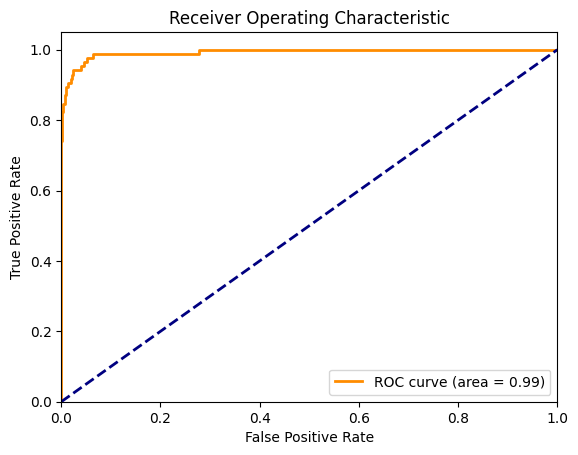

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Get predicted probabilities
y_prob = model_deep.predict(X_test)

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test_binary, y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()






In [ ]:
from sklearn.metrics import confusion_matrix

# Define costs
cost_fp = 10  # Cost of false positive
cost_fn = 50  # Cost of false negative

# Get predicted probabilities
y_prob = model_deep.predict(X_test)

# Define a range of thresholds
thresholds = np.linspace(0, 1, 100)

# Placeholder for best threshold
best_threshold = 0
min_cost = np.inf

# Loop through thresholds to find the one that minimizes cost
for threshold in thresholds:
    y_pred = (y_prob > threshold).astype(int)
    conf_mat = confusion_matrix(y_test_binary, y_pred)
    cost = cost_fp * conf_mat[0, 1] + cost_fn * conf_mat[1, 0]

    if cost < min_cost:
        min_cost = cost
        best_threshold = threshold

print(f"Best Threshold: {best_threshold:.2f}")

1238/1238 [==============================] - 5s 4ms/step
Best Threshold: 0.33


## SUM up
very precise, for both events (rae event @0.76) with a great ROC curve (most prediiction are achieved for low risk of false positive)
* let's try more layers of more neurons then fine-tune

# testing other architecture

More neurons

In [ ]:
model_deep = models.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model_deep.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history_deep = model_deep.fit(
    X_train, y_train_binary,
    epochs=100,
    batch_size=32,
    validation_split=0.2
)


Epoch 1/100
3960/3960 [==============================] - 17s 4ms/step - loss: 0.0147 - accuracy: 0.9979 - val_loss: 0.0092 - val_accuracy: 0.9981
Epoch 2/100
3960/3960 [==============================] - 29s 7ms/step - loss: 0.0094 - accuracy: 0.9981 - val_loss: 0.0066 - val_accuracy: 0.9983
Epoch 3/100
3960/3960 [==============================] - 17s 4ms/step - loss: 0.0082 - accuracy: 0.9982 - val_loss: 0.0065 - val_accuracy: 0.9983
Epoch 4/100
3960/3960 [==============================] - 14s 4ms/step - loss: 0.0075 - accuracy: 0.9983 - val_loss: 0.0061 - val_accuracy: 0.9982
Epoch 5/100
3960/3960 [==============================] - 15s 4ms/step - loss: 0.0071 - accuracy: 0.9984 - val_loss: 0.0055 - val_accuracy: 0.9983
Epoch 6/100
3960/3960 [==============================] - 14s 3ms/step - loss: 0.0068 - accuracy: 0.9986 - val_loss: 0.0051 - val_accuracy: 0.9987
Epoch 7/100
3960/3960 [==============================] - 14s 3ms/step - loss: 0.0066 - accuracy: 0.9985 - val_loss: 0.0059 -

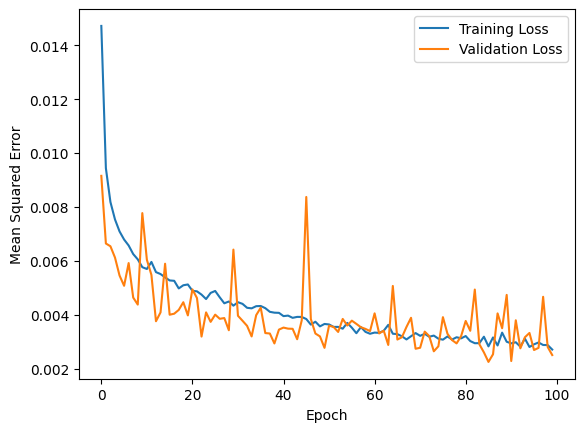

In [ ]:
import seaborn as sns

plt.plot(history_deep.history['loss'], label='Training Loss')
plt.plot(history_deep.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

# Predictions
y_pred = (model_deep.predict(X_test) > 0.5).astype(int)

# Confusion Matrix
conf_mat = confusion_matrix(y_test_binary, y_pred)
print(f"Confusion Matrix:\n{conf_mat}")

# Classification Report
class_rep = classification_report(y_test_binary, y_pred, target_names=['Class 0', 'Class 1'])
print(f"\nClassification Report:\n{class_rep}")

1238/1238 [==============================] - 3s 2ms/step
Confusion Matrix:
[[39508     2]
 [   34    51]]

Classification Report:
              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00     39510
     Class 1       0.96      0.60      0.74        85

    accuracy                           1.00     39595
   macro avg       0.98      0.80      0.87     39595
weighted avg       1.00      1.00      1.00     39595



1238/1238 [==============================] - 2s 2ms/step


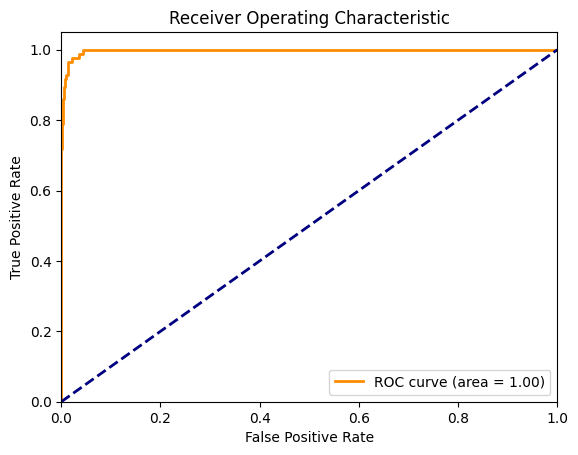

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Get predicted probabilities
y_prob = model_deep.predict(X_test)

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test_binary, y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# SUMup
Similar behaviour, let's try to perfect our model by ditching less important parameter : we isolate the msot important with random forest classifier :
Let's do a tree based selection to get most important params

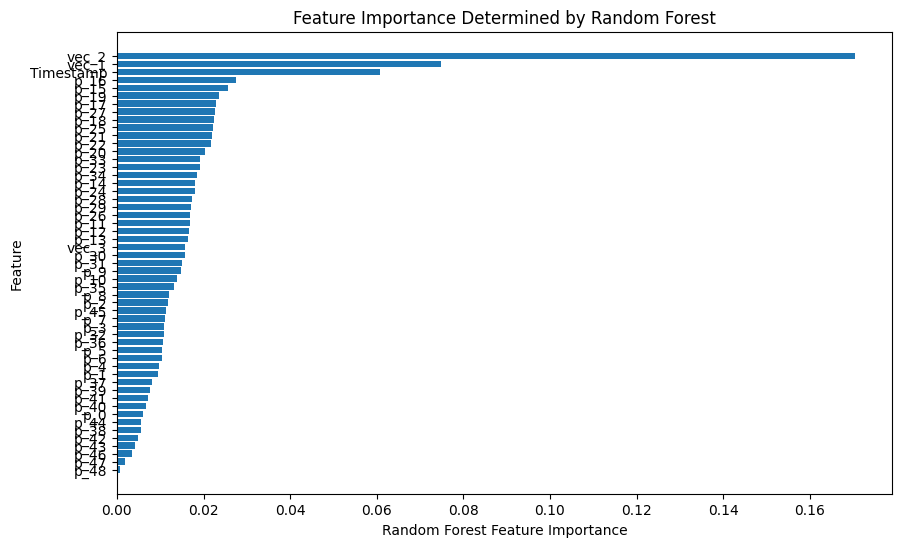

[('vec_2', 0.17044655967600647),
 ('vec_1', 0.07476766813730866),
 ('Timestamp', 0.06070111822837985),
 ('p_16', 0.02755534713877282),
 ('p_15', 0.02556655681604139),
 ('p_19', 0.02362959757930684),
 ('p_17', 0.022928851128844432),
 ('p_27', 0.022660205048564728),
 ('p_18', 0.022375462454901976),
 ('p_25', 0.02222384746923824),
 ('p_21', 0.021964361897853626),
 ('p_22', 0.021642062843499118),
 ('p_20', 0.020451381222000794),
 ('p_33', 0.01926537703706368),
 ('p_23', 0.019082827480005542),
 ('p_34', 0.01840481611808279),
 ('p_14', 0.018060838838072066),
 ('p_24', 0.017965802444406386),
 ('p_28', 0.01736628505264996),
 ('p_29', 0.017153601888417084),
 ('p_26', 0.016949583823624156),
 ('p_11', 0.016851363891334938),
 ('p_12', 0.01658003486779985),
 ('p_13', 0.016313799528944913),
 ('vec_3', 0.015745666389195907),
 ('p_30', 0.01573464414585638),
 ('p_31', 0.014963693397161238),
 ('p_9', 0.014852719404259371),
 ('p_10', 0.013988115838961429),
 ('p_35', 0.013178390346526916),
 ('p_8', 0.0121

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


# Initialize a Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train_binary)

# Get feature importances
feature_importances = rf.feature_importances_

# Plotting the Feature Importance
plt.figure(figsize=(10, 6))
sorted_idx = feature_importances.argsort()
plt.barh(X.columns[sorted_idx], feature_importances[sorted_idx])
plt.xlabel("Random Forest Feature Importance")
plt.ylabel("Feature")
plt.title("Feature Importance Determined by Random Forest")
plt.show()

# Output the features and their importances
feature_importance_dict = dict(zip(X.columns, feature_importances))
sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Features sorted by importance
sorted_feature_importance

In [ ]:
# Example: Selecting top N features
top_n = 25  # or any other number that makes sense based on the importance plot
selected_features_indices = [i for i, (feature, importance) in enumerate(sorted_feature_importance[:top_n])]

# Reduced feature set
X_train_reduced = X_train[:, selected_features_indices]
X_test_reduced = X_test[:, selected_features_indices]

Now we will implement drop out to reduce overfitting due to more neurons added

In [ ]:
model_deep_dropout = models.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train_reduced.shape[1],)),
    layers.Dropout(0.5),  # Added dropout
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),  # Added dropout
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.5),  # Added dropout
    layers.Dense(1, activation='sigmoid')
])

model_deep_dropout.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history_deep_dropout = model_deep_dropout.fit(
    X_train_reduced, y_train_binary,
    epochs=100,
    batch_size=32,
    validation_split=0.2
)

Epoch 1/100
3960/3960 [==============================] - 15s 3ms/step - loss: 0.0244 - accuracy: 0.9965 - val_loss: 0.0120 - val_accuracy: 0.9980
Epoch 2/100
3960/3960 [==============================] - 13s 3ms/step - loss: 0.0159 - accuracy: 0.9979 - val_loss: 0.0116 - val_accuracy: 0.9980
Epoch 3/100
3960/3960 [==============================] - 14s 4ms/step - loss: 0.0140 - accuracy: 0.9979 - val_loss: 0.0092 - val_accuracy: 0.9980
Epoch 4/100
3960/3960 [==============================] - 14s 3ms/step - loss: 0.0131 - accuracy: 0.9979 - val_loss: 0.0093 - val_accuracy: 0.9980
Epoch 5/100
3960/3960 [==============================] - 13s 3ms/step - loss: 0.0128 - accuracy: 0.9979 - val_loss: 0.0093 - val_accuracy: 0.9980
Epoch 6/100
3960/3960 [==============================] - 13s 3ms/step - loss: 0.0121 - accuracy: 0.9979 - val_loss: 0.0101 - val_accuracy: 0.9980
Epoch 7/100
3960/3960 [==============================] - 12s 3ms/step - loss: 0.0122 - accuracy: 0.9979 - val_loss: 0.0104 -

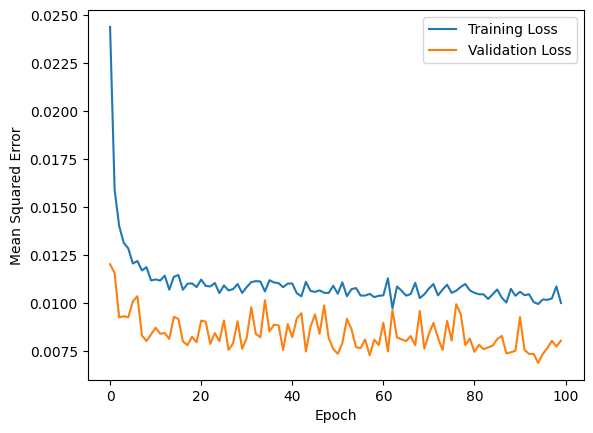

In [ ]:
plt.plot(history_deep_dropout.history['loss'], label='Training Loss')
plt.plot(history_deep_dropout.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

In [ ]:
# Predictions
y_pred = (model_deep_dropout.predict(X_test_reduced) > 0.5).astype(int)

# Confusion Matrix
conf_mat = confusion_matrix(y_test_binary, y_pred)
print(f"Confusion Matrix:\n{conf_mat}")

# Classification Report
class_rep = classification_report(y_test_binary, y_pred, target_names=['Class 0', 'Class 1'])
print(f"\nClassification Report:\n{class_rep}")

1238/1238 [==============================] - 2s 2ms/step
Confusion Matrix:
[[39510     0]
 [   64    21]]

Classification Report:
              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00     39510
     Class 1       1.00      0.25      0.40        85

    accuracy                           1.00     39595
   macro avg       1.00      0.62      0.70     39595
weighted avg       1.00      1.00      1.00     39595



In [ ]:
model_more_layers = models.Sequential([
    layers.Dense(32, activation='relu', input_shape=(X_train_reduced.shape[1],)),
    layers.Dropout(0.5),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(32, activation='relu'),  # Additional hidden layer
    layers.Dropout(0.5),
    layers.Dense(32, activation='relu'),  # Additional hidden layer
    layers.Dropout(0.5),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

model_more_layers.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history_more_layers = model_more_layers.fit(
    X_train_reduced, y_train_binary,
    epochs=100,
    batch_size=32,
    validation_split=0.2
)

Epoch 1/100
3960/3960 [==============================] - 16s 4ms/step - loss: 0.0267 - accuracy: 0.9972 - val_loss: 0.0134 - val_accuracy: 0.9980
Epoch 2/100
3960/3960 [==============================] - 15s 4ms/step - loss: 0.0170 - accuracy: 0.9979 - val_loss: 0.0132 - val_accuracy: 0.9980
Epoch 3/100
3960/3960 [==============================] - 26s 7ms/step - loss: 0.0167 - accuracy: 0.9979 - val_loss: 0.0137 - val_accuracy: 0.9980
Epoch 4/100
3960/3960 [==============================] - 26s 7ms/step - loss: 0.0163 - accuracy: 0.9979 - val_loss: 0.0133 - val_accuracy: 0.9980
Epoch 5/100
3960/3960 [==============================] - 18s 5ms/step - loss: 0.0159 - accuracy: 0.9979 - val_loss: 0.0135 - val_accuracy: 0.9980
Epoch 6/100
3960/3960 [==============================] - 16s 4ms/step - loss: 0.0152 - accuracy: 0.9979 - val_loss: 0.0128 - val_accuracy: 0.9980
Epoch 7/100
3960/3960 [==============================] - 14s 3ms/step - loss: 0.0157 - accuracy: 0.9979 - val_loss: 0.0135 -

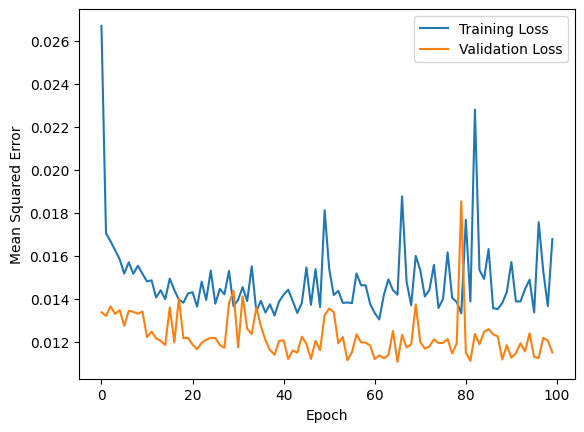

In [ ]:
plt.plot(history_more_layers.history['loss'], label='Training Loss')
plt.plot(history_more_layers.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

In [ ]:
# Predictions
y_pred = (model_more_layers.predict(X_test_reduced) > 0.5).astype(int)

# Confusion Matrix
conf_mat = confusion_matrix(y_test_binary, y_pred)
print(f"Confusion Matrix:\n{conf_mat}")

# Classification Report
class_rep = classification_report(y_test_binary, y_pred, target_names=['Class 0', 'Class 1'])
print(f"\nClassification Report:\n{class_rep}")

1238/1238 [==============================] - 4s 3ms/step
Confusion Matrix:
[[39510     0]
 [   85     0]]

Classification Report:
              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00     39510
     Class 1       0.00      0.00      0.00        85

    accuracy                           1.00     39595
   macro avg       0.50      0.50      0.50     39595
weighted avg       1.00      1.00      1.00     39595



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
model_more_layers = models.Sequential([
    layers.Dense(32, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dropout(0.5),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(32, activation='relu'),  # Additional hidden layer
    layers.Dropout(0.5),
    layers.Dense(32, activation='relu'),  # Additional hidden layer
    layers.Dropout(0.5),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

model_more_layers.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history_more_layers = model_more_layers.fit(
    X_train, y_train_binary,
    epochs=100,
    batch_size=32,
    validation_split=0.2
)

Epoch 1/100
3960/3960 [==============================] - 17s 4ms/step - loss: 0.0288 - accuracy: 0.9966 - val_loss: 0.0134 - val_accuracy: 0.9980
Epoch 2/100
3960/3960 [==============================] - 15s 4ms/step - loss: 0.0174 - accuracy: 0.9979 - val_loss: 0.0123 - val_accuracy: 0.9980
Epoch 3/100
3960/3960 [==============================] - 14s 3ms/step - loss: 0.0161 - accuracy: 0.9979 - val_loss: 0.0121 - val_accuracy: 0.9980
Epoch 4/100
3960/3960 [==============================] - 14s 4ms/step - loss: 0.0166 - accuracy: 0.9979 - val_loss: 0.0142 - val_accuracy: 0.9980
Epoch 5/100
3960/3960 [==============================] - 14s 4ms/step - loss: 0.0158 - accuracy: 0.9979 - val_loss: 0.0130 - val_accuracy: 0.9980
Epoch 6/100
3960/3960 [==============================] - 14s 4ms/step - loss: 0.0148 - accuracy: 0.9979 - val_loss: 0.0121 - val_accuracy: 0.9980
Epoch 7/100
3960/3960 [==============================] - 14s 4ms/step - loss: 0.0160 - accuracy: 0.9979 - val_loss: 0.0116 -

In [ ]:
plt.plot(history_more_layers.history['loss'], label='Training Loss')
plt.plot(history_more_layers_dropout.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

In [ ]:
# Predictions
y_pred = (model_more_layers.predict(X_test_reduced) > 0.5).astype(int)

# Confusion Matrix
conf_mat = confusion_matrix(y_test_binary, y_pred)
print(f"Confusion Matrix:\n{conf_mat}")

# Classification Report
class_rep = classification_report(y_test_binary, y_pred, target_names=['Class 0', 'Class 1'])
print(f"\nClassification Report:\n{class_rep}")